In [1]:
import sys
PATH_TO_ROOT='D:/My Repository'
sys.path.insert(0, PATH_TO_ROOT)

In [2]:
import pandas as pd
import numpy as np
from loess import loess_1d
from sklearn import linear_model
import matplotlib.pyplot as plt

from AlphaMobileSensing.env import environment

In [3]:
datapath='D:/Research Working Folder/Paper_1-Mobile Sensing Virtual Environment/dynamic_50cm_DEMO.csv'
env=environment.AlphaMoSeEnv(datapath, 2500, 1, 2, (15, 15), ((3.5, 3), (65.6, 8)), 2, (0.5, 0.5), 1000)
action_series_df=pd.read_excel('D:/My Repository/AlphaMobileSensing/data/action series for demo_multiple_test.xlsx')

C:\Users\qizho\AppData\Roaming\Python\Python39\site-packages\gym\spaces\box.py:112: UserWarning: WARN: Box bound precision lowered by casting to float64
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [4]:
action_series_df

,Ux,Uy,tau,Continue/Stop,Ux.1,Uy.1,tau.1,Continue/Stop.1
0,0.0,0.2,25,1,0.0,-0.2,25,1
1,0.0,0.2,25,1,0.0,-0.2,25,1
2,0.1,0.0,45,1,-0.1,0.0,45,1
3,0.0,-0.2,25,1,0.0,0.2,25,1
4,0.0,-0.2,25,1,0.0,0.2,25,1
5,0.1,0.0,45,1,-0.1,0.0,45,1
6,0.0,0.2,25,1,0.0,0.2,30,1
7,0.0,0.2,25,1,0.0,0.2,30,1
8,0.1,0.0,45,1,-0.1,0.0,45,1
9,0.0,-0.1,55,1,0.0,-0.2,30,1


In [5]:
env.reset()

num_agent=2


measurement_log_raw=np.full((len(action_series_df)+1,4*num_agent), np.nan)

for i in range(num_agent):
    measurement_log_raw[0,4*i:4*(i+1)]=env.obs[i]


for i in range(len(action_series_df)):
 
    action=[]
    for j in range(num_agent):
        array=action_series_df.iloc[i,4*j:4*(j+1)].values
        action.append(array)

    step_log=env.step(action)

    
    if step_log[0]==True:
        break
    else:
        for j in range(num_agent):
            measurement_log_raw[i+1,4*j:4*(j+1)]=env.obs[j]

In [6]:
env.agent_global_time

array([1005.,  940.])

In [7]:
measurement_log_middle=np.zeros(((len(action_series_df)+1)*num_agent,4))
for i in range(num_agent):
    measurement_log_middle[(len(action_series_df)+1)*i:(len(action_series_df)+1)*(i+1),:]=measurement_log_raw[:,4*i:4*(i+1)]

In [8]:
b=measurement_log_middle[:,2]
index=np.lexsort((b,))
measurement_log_middle=measurement_log_middle[index]


measurement_log=measurement_log_middle[~np.isnan(measurement_log_middle)]
measurement_log=measurement_log.reshape((-1,4))

In [9]:
x=measurement_log[:,0]
y=measurement_log[:,1]
t=measurement_log[:, 2]
v=measurement_log[:, 3]

fglobal=loess_1d.loess_1d(x=t,y=v, xnew=t)

r_i=v-fglobal[1]

In [10]:
nor_measurement_log=np.zeros_like(measurement_log)
for i in range(3):
    nor_measurement_log[:,i]=(measurement_log[:,i]-measurement_log[:,i].min())/(measurement_log[:,i].max()-measurement_log[:,i].min())

In [11]:
reg=linear_model.LinearRegression()
reg.fit(nor_measurement_log[:, 0:3], r_i)

LinearRegression()

In [12]:
target_time=1005

xgrid=np.mgrid[-0.5:73.55:100j, -3:22.95:100j]
xflat = xgrid.reshape(2, -1).T
t_array=np.zeros((10000,1))+target_time
xflat=np.concatenate([xflat, t_array], axis=1)

nor_xflat=np.zeros((10000,3))
for i in range(3):
    nor_xflat[:,i]=(xflat[:,i]-measurement_log[:,i].min())/(measurement_log[:,i].max()-measurement_log[:,i].min())
    

fglobal=loess_1d.loess_1d(x=t,y=v, xnew=np.array([target_time]))

newz=fglobal[1]+reg.intercept_+reg.coef_[0]*nor_xflat[:,0]+reg.coef_[1]*nor_xflat[:,1]+reg.coef_[2]*nor_xflat[:,2]

In [13]:
data=env.stdata[['X', 'Y']]

delta=1.5

for i in range(10000):
    bb=xflat[i,:]
    judge_array=[0,0,0,0]
    window_data=data.loc[(data['X']>(bb[0]-delta)) & (data['X']<(bb[0]+delta)) & 
    (data['Y']>(bb[1]-delta)) & (data['Y']<(bb[1]+delta)), ['X', 'Y']]
    judge_array[0]=window_data.loc[(window_data['X']<bb[0]) & (window_data['Y']<bb[1])].empty
    judge_array[1]=window_data.loc[(window_data['X']<bb[0]) & (window_data['Y']>bb[1])].empty
    judge_array[2]=window_data.loc[(window_data['X']>bb[0]) & (window_data['Y']<bb[1])].empty
    judge_array[3]=window_data.loc[(window_data['X']>bb[0]) & (window_data['Y']>bb[1])].empty
    if True in judge_array:
        newz[i]=np.nan 


ygrid = newz.reshape(100, 100)

(-0.5, 73.55, -3.0, 22.95)

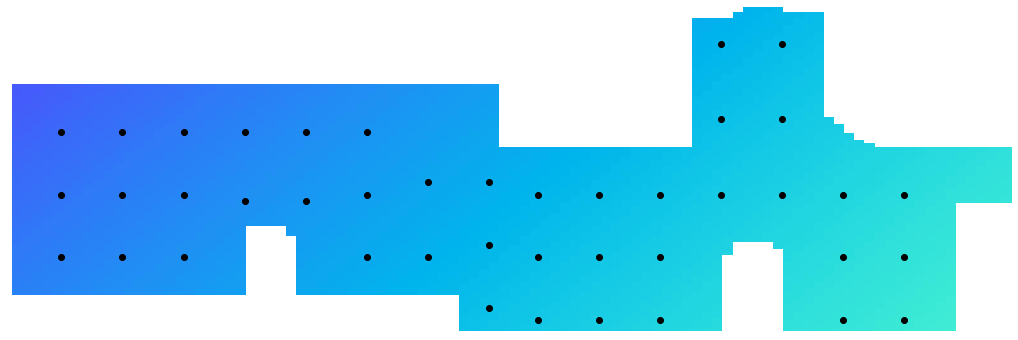

In [14]:
fig, ax=plt.subplots(1,1,figsize=(18,6))
im=ax.pcolormesh(*xgrid, ygrid, shading='auto', cmap='rainbow', vmin=295, vmax=301)

im_m=ax.plot(x, y, "ok", label="input point")

ax.set_xlim(-0.5,73.55)
ax.set_ylim(-3,22.95)

ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.axis('off')

In [15]:
stationary_sensing=env.stationary_monitoring()

#three stationary sensors are set

In [16]:
stationary_sensing

(   X coordinate  Y coordinate
 1           3.5           3.0
 2          36.0           6.0
 3          62.0          -1.0,
        time   sensor #1   sensor #2   sensor #3
 0       0.0  300.000000  300.000000  300.000000
 1      20.0  298.144043  300.001739  300.048340
 2      40.0  298.201050  299.036529  300.113220
 3      60.0  297.871124  299.168427  298.803192
 4      80.0  297.780212  299.115234  298.274292
 ..      ...         ...         ...         ...
 120  2400.0  296.414551  296.140564  296.861694
 121  2420.0  296.175537  296.144714  297.015564
 122  2440.0  296.242889  296.168396  297.076416
 123  2460.0  296.060120  296.189362  297.073029
 124  2480.0  296.213440  296.186707  297.055237
 
 [125 rows x 4 columns])

In [17]:
stationary_sensing[1]

,time,sensor #1,sensor #2,sensor #3
0,0.0,300.000000,300.000000,300.000000
1,20.0,298.144043,300.001739,300.048340
2,40.0,298.201050,299.036529,300.113220
3,60.0,297.871124,299.168427,298.803192
4,80.0,297.780212,299.115234,298.274292
...,...,...,...,...
120,2400.0,296.414551,296.140564,296.861694
121,2420.0,296.175537,296.144714,297.015564
122,2440.0,296.242889,296.168396,297.076416
123,2460.0,296.060120,296.189362,297.073029


In [18]:
env.request_evaluation()

In [19]:
template=pd.read_csv('D:/My Repository/AlphaMobileSensing/demo/Template_demo_Multiple_1005.csv')

X=template.iloc[:,1].values
Y=template.iloc[:,2].values

nor_X=np.zeros(len(template))
nor_Y=np.zeros(len(template))

for i in range(2):
    nor_X[:]=(X[:]-measurement_log[:,i].min())/(measurement_log[:,i].max()-measurement_log[:,i].min())
    nor_Y[:]=(Y[:]-measurement_log[:,i].min())/(measurement_log[:,i].max()-measurement_log[:,i].min())

Z=fglobal[1]+reg.intercept_+reg.coef_[0]*nor_X[:]+reg.coef_[1]*nor_Y[:]+reg.coef_[2]*nor_xflat[0,2]

for i in range(len(template)):
    template.iloc[i,3]=Z[i]

template.to_csv('D:/My Repository/AlphaMobileSensing/demo/Template_demo_Multiple_1005.csv', index=0)

env.compute_accuracy()

{'Root mean square error': 1.6322891137243623,
 'Mean absolute error': 1.5554000329055384}